<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/vitalfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vital 파일 다루기
Vital Recorder 에서 생성한 Vital 파일을 파이선으로 읽어오는 방법을 알아보겠습니다.

## 샘플 vital 파일 다운로드
아래 코드를 실행하여 vitaldb 의 샘플 vital 파일을 다운로드 합니다.

In [1]:
!wget -N https://vitaldb.net/samples/00001.vital

--2020-11-11 08:44:13--  https://vitaldb.net/samples/00001.vital
Resolving vitaldb.net (vitaldb.net)... 52.78.107.13, 3.35.144.143
Connecting to vitaldb.net (vitaldb.net)|52.78.107.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21369609 (20M) [application/octet-stream]
Saving to: ‘00001.vital’

00001.vital         100%[===================>]  20.38M  5.48MB/s    in 3.7s    

2020-11-11 08:44:17 (5.48 MB/s) - ‘00001.vital’ saved [21369609/21369609]



## Vital 파일을 읽기 위한 라이브러리 다운로드

github에 공개된 vitalutils 코드 중 vital 파일을 읽기 위한 vitaldb 모듈을 읽어옵니다.

In [2]:
!wget https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py

--2020-11-11 08:44:17--  https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15185 (15K) [text/plain]
Saving to: ‘vitaldb.py’

vitaldb.py          100%[===================>]  14.83K  --.-KB/s    in 0.004s  

2020-11-11 08:44:18 (3.96 MB/s) - ‘vitaldb.py’ saved [15185/15185]



## Vital 파일 트랙 목록 읽기
vital_trks 함수를 사용하여 개인이 보유한 vital 파일을 내용을 읽습니다. 본 예제에서는 위에서 다운로드 한 00001.vital 파일을 읽어보겠습니다.

In [3]:
import numpy as np
import vitaldb

trks = vitaldb.vital_trks("00001.vital")
trks

['/EVENT',
 'SNUADC/ART',
 'SNUADC/ECG_II',
 'SNUADC/ECG_V5',
 'SNUADC/PLETH',
 'Solar 8000M/HR',
 'Solar 8000M/ST_I',
 'Solar 8000M/ST_II',
 'Solar 8000M/ST_III',
 'Solar 8000M/ST_AVL',
 'Solar 8000M/ST_AVR',
 'Solar 8000M/ST_AVF',
 'Solar 8000M/ART_MBP',
 'Solar 8000M/ART_SBP',
 'Solar 8000M/ART_DBP',
 'Solar 8000M/PLETH_SPO2',
 'Solar 8000M/PLETH_HR',
 'Solar 8000M/BT',
 'Solar 8000M/VENT_MAWP',
 'Solar 8000M/ST_V5',
 'Solar 8000M/NIBP_MBP',
 'Solar 8000M/NIBP_SBP',
 'Solar 8000M/NIBP_DBP',
 'Solar 8000M/VENT_PIP',
 'Solar 8000M/VENT_RR',
 'Solar 8000M/VENT_MV',
 'Solar 8000M/VENT_TV',
 'Solar 8000M/VENT_PPLAT',
 'Solar 8000M/GAS2_AGENT',
 'Solar 8000M/GAS2_EXPIRED',
 'Solar 8000M/GAS2_INSPIRED',
 'Solar 8000M/ETCO2',
 'Solar 8000M/INCO2',
 'Solar 8000M/RR_CO2',
 'Solar 8000M/FEO2',
 'Solar 8000M/FIO2',
 'Solar 8000M/VENT_INSP_TM',
 'Solar 8000M/VENT_SET_TV',
 'Solar 8000M/VENT_SET_PCP',
 'Primus/CO2',
 'Primus/AWP',
 'Primus/INSP_SEVO',
 'Primus/EXP_SEVO',
 'Primus/PAMB_MBAR',
 'Pr

## Vital 파일 내용 읽기
vital_recs 함수를 사용하여 개인이 보유한 vital 파일을 내용을 읽습니다. 본 예제에서는 위에서 다운로드 한 00001.vital 파일을 읽어보겠습니다.

어떤 트랙을 읽을지, 한 행은 몇 초 간격으로 읽을지를 지정해야합니다. 트랙 목록을 지정할 때는 `장비명1/트랙명1,장비명2/트랙명2` 형태로 합니다.

In [26]:
import numpy as np
import vitaldb

vals = vitaldb.vital_recs("00001.vital", 'SNUADC/ECG_II,SNUADC/ART,Solar 8000M/ST_II', 0.01)
vals

array([[         nan,          nan,          nan],
       [         nan,          nan,          nan],
       [         nan,          nan,          nan],
       ...,
       [ -0.28558824, -12.75951172,          nan],
       [  0.16864199,  30.68859766,          nan],
       [  0.38588254, -16.70933984,          nan]])

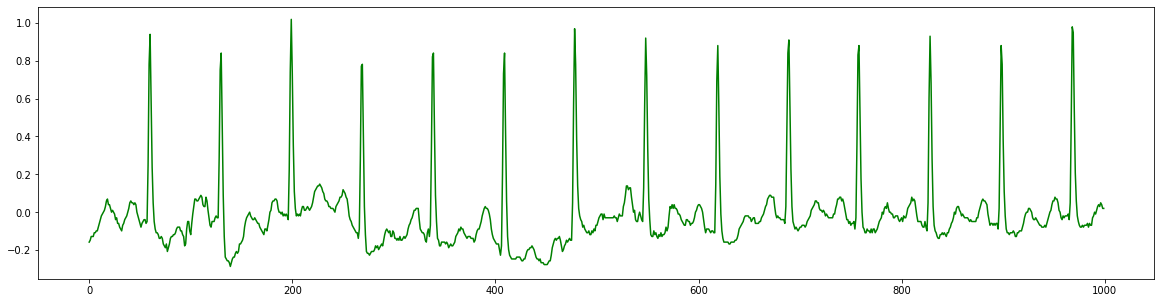

In [16]:
# ecg 트랙을 그림
ecg = vals[:,0]
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(ecg[6000:7000], color='g')
plt.show()

In [27]:
# st 트랙의 유효한 값을 출력
st = vals[:,2]
st_valid = st[~np.isnan(st)]
st_valid

array([-0.2, -0.2, -0.2, ...,  0. ,  0. ,  0. ])

## 생체 신호 처리 라이브러리 이용

In [20]:
!wget -N https://raw.githubusercontent.com/vitaldb/pyvital/master/arr.py
import arr

--2020-11-11 08:50:38--  https://raw.githubusercontent.com/vitaldb/pyvital/master/arr.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21014 (21K) [text/plain]
Saving to: ‘arr.py’

arr.py              100%[===================>]  20.52K  --.-KB/s    in 0.004s  

Last-modified header missing -- time-stamps turned off.
2020-11-11 08:50:38 (4.69 MB/s) - ‘arr.py’ saved [21014/21014]



[60, 130, 199, 269, 339, 409, 478, 548, 619, 689, 758, 828, 898, 968]

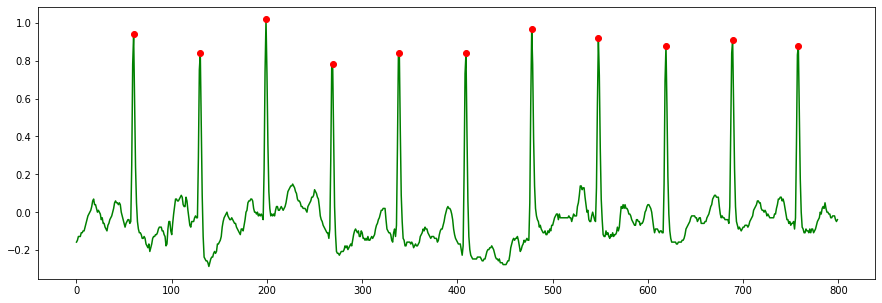

In [24]:
ecg = vals[6000:6800, 0]
ecg = arr.exclude_undefined(ecg)
peaks = arr.detect_qrs(ecg, 100)

plt.figure(figsize=(15,5))
plt.plot(ecg, color='g')
plt.plot(peaks, [ecg[i] for i in peaks], 'ro')
plt.show()

[[101, 171, 238, 308, 377, 447, 515, 585, 655, 724], [52, 123, 191, 256, 329, 395, 465, 533, 602, 673, 743]]


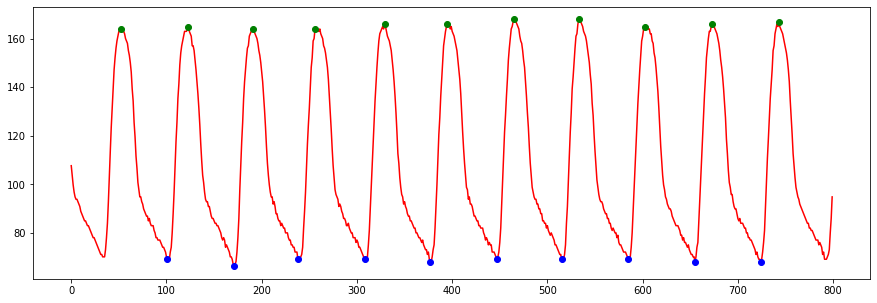

In [33]:
art = vals[300000:300800, 1]
art = arr.exclude_undefined(art)
peaks = arr.detect_peaks(art, 100)
print(peaks)

plt.figure(figsize=(15,5))
plt.plot(art, color='r')
plt.plot(peaks[0], [art[i] for i in peaks[0]], 'bo')
plt.plot(peaks[1], [art[i] for i in peaks[1]], 'go')
plt.show()